In [19]:
# 載入需要的套件
import os
import numpy as np 
import pandas as pd
import copy
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, BaggingRegressor
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
%matplotlib inline

In [101]:
# 設定 data_path
dir_data = './data/'
Train = os.path.join(dir_data, 'train.csv')
Test = os.path.join(dir_data, 'test.csv')

# 讀取檔案
Train_data = pd.read_csv(Train)
Test_data = pd.read_csv(Test)

In [102]:
train_Y = np.log1p(Train_data['total_price'])
ids = Test_data['building_id']

tp = copy.deepcopy(np.log1p(Train_data['total_price']))

Train_data = Train_data.drop(['building_id', 'total_price'] , axis=1)
Test_data = Test_data.drop(['building_id'] , axis=1)

df = pd.concat([Train_data,Test_data])
df.head()

,building_material,city,txn_dt,total_floor,building_type,building_use,building_complete_dt,parking_way,parking_area,parking_price,...,XIV_250,XIV_500,XIV_index_500,XIV_1000,XIV_index_1000,XIV_5000,XIV_index_5000,XIV_10000,XIV_index_10000,XIV_MIN
0,8,21,18674,4,3,2,6271,2,NaN,NaN,...,21,58,1,157,1,2483,1,6011,1,34.469803
1,8,7,18800,5,1,2,7885,2,NaN,NaN,...,7,28,1,115,1,15872,1,32221,1,40.073573
2,8,7,19289,4,1,2,6028,2,NaN,NaN,...,27,78,1,212,1,15760,1,32228,1,54.462081
3,8,21,20385,24,0,2,18325,0,NaN,81138.889762,...,2,20,1,125,1,2568,1,7271,1,99.628966
4,1,21,20657,2,4,2,6880,2,NaN,NaN,...,2,18,1,47,1,2587,1,7442,1,124.131236


In [103]:
df = df.fillna(-1)
train_num = train_Y.shape[0]
train_X = df[:train_num]
test_X = df[train_num:]

In [58]:
estimator = RandomForestRegressor(max_depth=20)
estimator.fit(train_X, train_Y)
feats = pd.Series(data=estimator.feature_importances_, index=df.columns)
feats = feats.sort_values(ascending=False)
#feats

In [18]:
cross_val_score(estimator, train_X, train_Y, cv=5).mean()

0.946078274922838

In [53]:
# 高重要性特徵，經測試取前37個效果為最佳
high_feature = list(feats[:37].index)
train_X_ = train_X[high_feature]
cross_val_score(estimator, train_X_, train_Y, cv=5).mean()

0.9492400844012309

In [68]:
high_feature = list(feats[:37].index)
estimator_ = RandomForestRegressor(max_depth=20)
estimator_.fit(train_X[high_feature], train_Y)

predict = estimator_.predict(test_X[high_feature])

test_price = np.expm1(predict)

submit = pd.DataFrame(ids)
submit['total_price'] = test_price.astype(np.int32)
submit.to_csv("2019-05-31.csv",index=False)

In [104]:
from sklearn.linear_model import Lasso
L1_Reg = Lasso(alpha=0.000005)
MMEncoder = MinMaxScaler()
train_X = MMEncoder.fit_transform(train_X)
L1_Reg.fit(train_X, train_Y)
#L1_Reg.coef_

/home/rex/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Lasso(alpha=5e-06, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [105]:
from itertools import compress
L1_mask = list(abs(L1_Reg.coef_)>0)
L1_list = list(compress(list(train_X), list(L1_mask)))
#L1_list

In [81]:
train_X_ = train_X[L1_list]
cross_val_score(estimator, train_X_, train_Y, cv=5).mean()

0.9466210498100425

In [106]:
MMEncoder = MinMaxScaler()
train_X = MMEncoder.fit_transform(train_X[L1_list])
test_X = MMEncoder.fit_transform(test_X[L1_list])

estimator_ = RandomForestRegressor()
estimator_.fit(train_X, train_Y)

predict = estimator_.predict(test_X)

test_price = np.expm1(predict)

submit = pd.DataFrame(ids)
submit['total_price'] = test_price.astype(np.int32)
submit.to_csv("2019-05-31.csv",index=False)

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [109]:
test_X

,building_material,city,txn_dt,total_floor,building_type,building_use,building_complete_dt,parking_way,parking_area,parking_price,...,XIV_250,XIV_500,XIV_index_500,XIV_1000,XIV_index_1000,XIV_5000,XIV_index_5000,XIV_10000,XIV_index_10000,XIV_MIN
0,1,13,18634,2,4,2,1857,2,-1.000000,-1.000000,...,7,21,1,129,1,3991,1,8409,1,105.462231
1,8,7,20199,10,3,2,16011,2,-1.000000,-1.000000,...,18,44,1,67,1,1950,1,10725,1,100.819809
2,8,12,19769,4,4,10,18294,2,-1.000000,-1.000000,...,0,3,1,35,1,3707,1,19459,1,259.800543
3,10,7,20479,19,2,0,17837,2,-1.000000,-1.000000,...,16,60,1,144,1,6487,1,29400,1,22.941906
4,8,3,18164,13,0,2,13272,2,-1.000000,-1.000000,...,4,18,1,76,1,1346,1,3280,1,181.213095
5,8,12,18632,4,4,2,15464,2,-1.000000,-1.000000,...,7,19,1,88,1,2144,1,5477,1,206.701060
6,8,7,19144,14,0,2,16590,0,-1.000000,61488.568950,...,17,64,1,380,1,9419,1,23499,1,77.249329
7,8,13,19452,5,1,2,7124,2,-1.000000,-1.000000,...,3,22,1,273,1,2729,1,12880,1,155.031982
8,1,17,19045,2,4,2,12634,2,-1.000000,-1.000000,...,2,11,1,27,1,459,1,1693,1,81.407991
9,8,7,19220,13,2,10,17351,2,-1.000000,-1.000000,...,4,17,1,127,1,5742,1,23399,1,16.357214


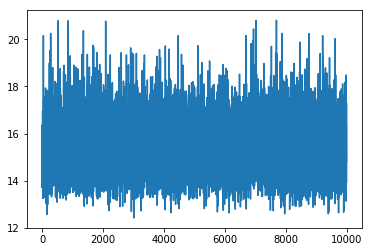

In [86]:
plt.plot(predict)
plt.show()